## 1. Setup and Data Loading

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [39]:
# Load preprocessed data
df = pd.read_csv('preprocessed_final.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
df.head()

Dataset loaded: (1785, 68)
Date range: 1996-06-13 to 2020-02-27


,date,next_trading_day,speaker,Positive,Negative,Polarity,LM_pos_rate,LM_neg_rate,LM_net_polarity_per_token,fomc_hawk,...,target_NDQ_1d,target_NDQ_5d,class_SP500_1d,class_SP500_5d,class_RSL_1d,class_RSL_5d,class_DJIA_1d,class_DJIA_5d,class_NDQ_1d,class_NDQ_5d
0,1996-12-19,1996-12-20,Vice Chair Alice M. Rivlin,50,88,-0.275362,0.029638,0.052164,-0.022525,0.000294,...,-0.003616,0.009195,Neutral,Neutral,Neutral,Neutral,Bearish,Neutral,Neutral,Neutral
1,1996-12-06,1996-12-09,Chairman Alan Greenspan,59,70,-0.085271,0.046975,0.055732,-0.008758,0.099280,...,0.002247,-0.027768,Neutral,Bearish,Neutral,Bearish,Bearish,Bearish,Neutral,Bearish
2,1996-12-05,1996-12-06,Chairman Alan Greenspan,62,137,-0.376884,0.033550,0.074134,-0.040584,0.002163,...,0.014037,-0.003713,Bullish,Bearish,Bullish,Bearish,Bullish,Neutral,Bullish,Neutral
3,1996-12-03,1996-12-04,"Governor Edward W. Kelley, Jr.",36,59,-0.242105,0.028916,0.047390,-0.018474,0.000181,...,0.002653,-0.001117,Neutral,Neutral,Neutral,Neutral,Neutral,Bullish,Neutral,Neutral
4,1996-11-25,1996-11-26,Governor Susan M. Phillips,52,32,0.238095,0.047575,0.029277,0.018298,0.000161,...,0.003671,0.019125,Neutral,Bearish,Neutral,Bearish,Neutral,Neutral,Neutral,Bullish


## 2. Prepare Features and Target

In [40]:
# Define columns
metadata_cols = ['date', 'next_trading_day', 'speaker']
target_cols = [c for c in df.columns if c.startswith('target_') or c.startswith('class_')]
feature_cols = [c for c in df.columns if c not in metadata_cols + target_cols]

print(f"Features: {len(feature_cols)}")
print(f"Targets: {len(target_cols)}")

Features: 49
Targets: 16


In [41]:
# Primary target: S&P 500 next-day classification
primary_target = 'class_SP500_1d'

X = df[feature_cols].copy()
y = df[primary_target].copy()

# Encode target labels
label_mapping = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}
y_encoded = y.map(label_mapping)

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")


Target distribution:
class_SP500_1d
Neutral    911
Bullish    491
Bearish    383
Name: count, dtype: int64

Features shape: (1785, 49)
Target shape: (1785,)


In [48]:
# 🔄 OVERRIDE: Switch to 5-day target for better predictability
primary_target = 'class_SP500_5d'
y = df[primary_target].copy()
y_encoded = y.map(label_mapping)

print(f"\n📊 NEW TARGET: {primary_target}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Percentage distribution:")
print(y.value_counts(normalize=True).round(3))
print(f"\nTarget shape: {y_encoded.shape}")


📊 NEW TARGET: class_SP500_5d
Target distribution:
class_SP500_5d
Neutral    829
Bullish    562
Bearish    394
Name: count, dtype: int64
Percentage distribution:
class_SP500_5d
Neutral    0.464
Bullish    0.315
Bearish    0.221
Name: proportion, dtype: float64

Target shape: (1785,)


## 2.5. Alternative Target: Binary "Large Movement" Prediction

In [55]:
# Create binary target: Does speech cause significant movement?
# Hypothesis: Fed speeches matter when they cause LARGE moves, not just direction

# Use 1% threshold for "large" movement
threshold = 0.01

# Create binary target from raw returns (1d)
df['large_move_1d'] = (df['target_SP500_1d'].abs() > threshold).astype(int)

# Also for 5d
df['large_move_5d'] = (df['target_SP500_5d'].abs() > threshold).astype(int)

print("📊 BINARY TARGET: Large Movement Detection")
print(f"\n1-Day Large Movements (>{threshold*100}%):")
print(df['large_move_1d'].value_counts())
print(f"Percentage: {df['large_move_1d'].value_counts(normalize=True).round(3)}")

print(f"\n5-Day Large Movements (>{threshold*100}%):")
print(df['large_move_5d'].value_counts())
print(f"Percentage: {df['large_move_5d'].value_counts(normalize=True).round(3)}")

📊 BINARY TARGET: Large Movement Detection

1-Day Large Movements (>1.0%):
large_move_1d
0    1311
1     474
Name: count, dtype: int64
Percentage: large_move_1d
0    0.734
1    0.266
Name: proportion, dtype: float64

5-Day Large Movements (>1.0%):
large_move_5d
1    1045
0     740
Name: count, dtype: int64
Percentage: large_move_5d
1    0.585
0    0.415
Name: proportion, dtype: float64


In [56]:
# 🎯 Switch to binary large movement target (5-day)
primary_target = 'large_move_5d'
y = df[primary_target].copy()
y_encoded = y  # Already 0/1, no mapping needed

label_mapping_binary = {0: 'Small Move', 1: 'Large Move'}

print(f"\n🎯 ACTIVE TARGET: {primary_target}")
print(f"Target distribution:")
print(f"  Small moves (<1%): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Large moves (>1%): {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"\nTarget shape: {y_encoded.shape}")


🎯 ACTIVE TARGET: large_move_5d
Target distribution:
  Small moves (<1%): 740 (41.5%)
  Large moves (>1%): 1045 (58.5%)

Target shape: (1785,)


## 3. Train-Test Split (Time-Based)

In [57]:
# 80/20 split, preserving temporal order
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded.iloc[:split_index]
y_test = y_encoded.iloc[split_index:]

train_dates = df['date'].iloc[:split_index]
test_dates = df['date'].iloc[split_index:]

print(f"Training: {len(X_train)} samples ({train_dates.min().date()} to {train_dates.max().date()})")
print(f"Testing: {len(X_test)} samples ({test_dates.min().date()} to {test_dates.max().date()})")
print(f"\nTraining class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest class distribution:\n{y_test.value_counts().sort_index()}")

Training: 1428 samples (1996-06-13 to 2013-12-16)
Testing: 357 samples (2013-01-04 to 2020-02-27)

Training class distribution:
large_move_5d
0    579
1    849
Name: count, dtype: int64

Test class distribution:
large_move_5d
0    161
1    196
Name: count, dtype: int64


## 3.5. Apply SMOTE Oversampling (Recommendation #1)

In [58]:
# Apply SMOTE to balance training data
# SMOTE creates synthetic samples for minority classes
print("Original training distribution:")
print(y_train.value_counts().sort_index())

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training samples: {len(X_train)} → {len(X_train_smote)}")
print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())
print("\n✅ SMOTE oversampling applied!")

Original training distribution:
large_move_5d
0    579
1    849
Name: count, dtype: int64

After SMOTE:
Training samples: 1428 → 1698

Class distribution after SMOTE:
large_move_5d
0    849
1    849
Name: count, dtype: int64

✅ SMOTE oversampling applied!


## 4. Baseline Model

In [59]:
# Baseline: Always predict most common class
most_common_class = y_train.mode()[0]
baseline_pred = np.full(len(y_test), most_common_class)
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline: Always predict class {most_common_class}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")


Baseline: Always predict class 1
Baseline Accuracy: 0.5490


## 5. Train Random Forest

In [60]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

print("Training Random Forest")
rf_model.fit(X_train, y_train)


Training Random Forest


,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6. Evaluate Performance

In [61]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"\nBaseline:  {baseline_acc:.4f}")
print(f"Improvement: {(acc - baseline_acc)*100:.2f}%")
print("="*60)

RANDOM FOREST RESULTS
Accuracy:  0.5266
Precision: 0.5263
Recall:    0.5266
F1 Score:  0.5265

Baseline:  0.5490
Improvement: -2.24%


In [63]:
# Detailed classification report (binary)
print("\nDetailed Classification Report:")
if len(np.unique(y_test)) == 2:
    # Binary classification
    print(classification_report(y_test, y_pred, target_names=['Small Move', 'Large Move'], zero_division=0))
else:
    # Multi-class
    print(classification_report(y_test, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'], zero_division=0))


Detailed Classification Report:
              precision    recall  f1-score   support

  Small Move       0.47      0.47      0.47       161
  Large Move       0.57      0.57      0.57       196

    accuracy                           0.53       357
   macro avg       0.52      0.52      0.52       357
weighted avg       0.53      0.53      0.53       357



In [62]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'], zero_division=0))


Detailed Classification Report:


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

## 7. Confusion Matrix

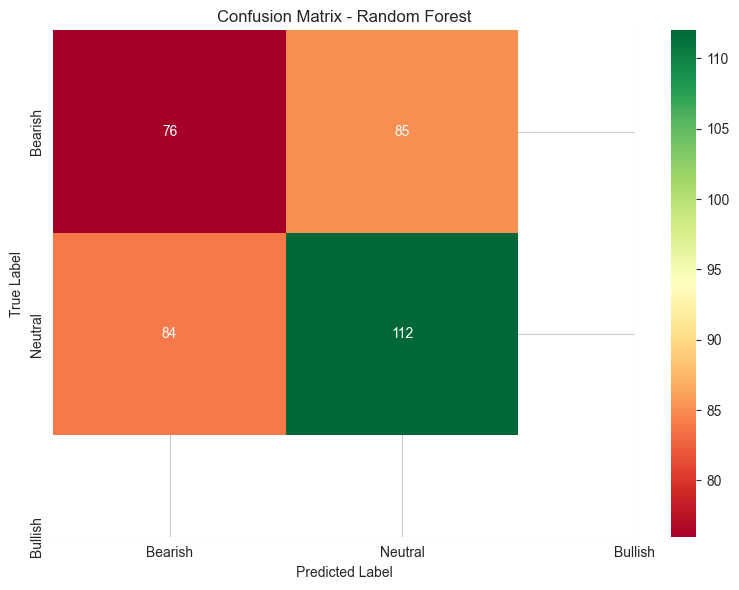

Confusion Matrix:
[[ 76  85]
 [ 84 112]]


In [64]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=['Bearish', 'Neutral', 'Bullish'],
            yticklabels=['Bearish', 'Neutral', 'Bullish'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)

## 8. Feature Importance

In [65]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
          feature  importance
      RSL_vol_20d    0.080270
     DJIA_vol_20d    0.074304
    SP500_vol_20d    0.056232
      NDQ_vol_20d    0.038821
      RSL_ret_20d    0.038035
      NDQ_ret_20d    0.036173
    SP500_ret_20d    0.034000
     DJIA_ret_20d    0.031597
     SP500_ret_5d    0.030033
      DJIA_ret_5d    0.027856
     SP500_ret_1d    0.026550
       NDQ_ret_5d    0.025893
       RSL_ret_5d    0.025754
       NDQ_ret_1d    0.025729
      DJIA_ret_1d    0.025276
    finbert_score    0.022248
       RSL_ret_1d    0.021903
         n_tokens    0.020370
        fomc_hawk    0.018805
fed interest rate    0.018172


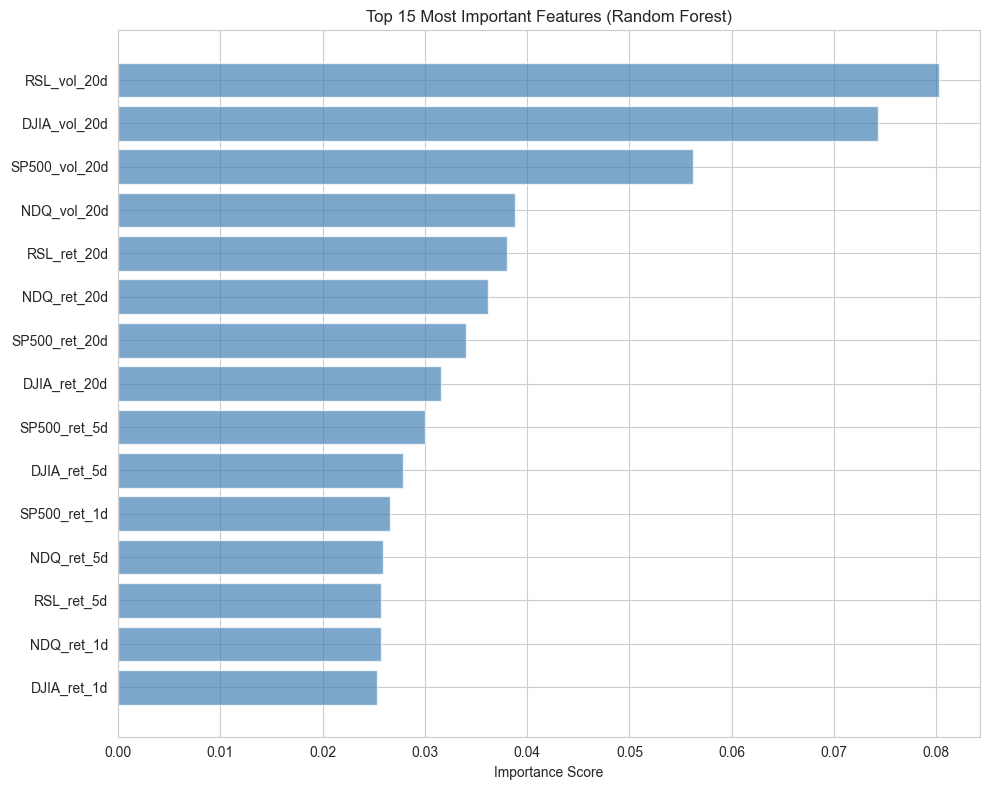

In [66]:
# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Feature Importance by Category


Feature Importance by Category:
category
Market Context    0.598424
Sentiment         0.145023
Topics            0.137469
Temporal          0.044579
Macro             0.034853
Speaker           0.023246
Other             0.016406
Name: importance, dtype: float64


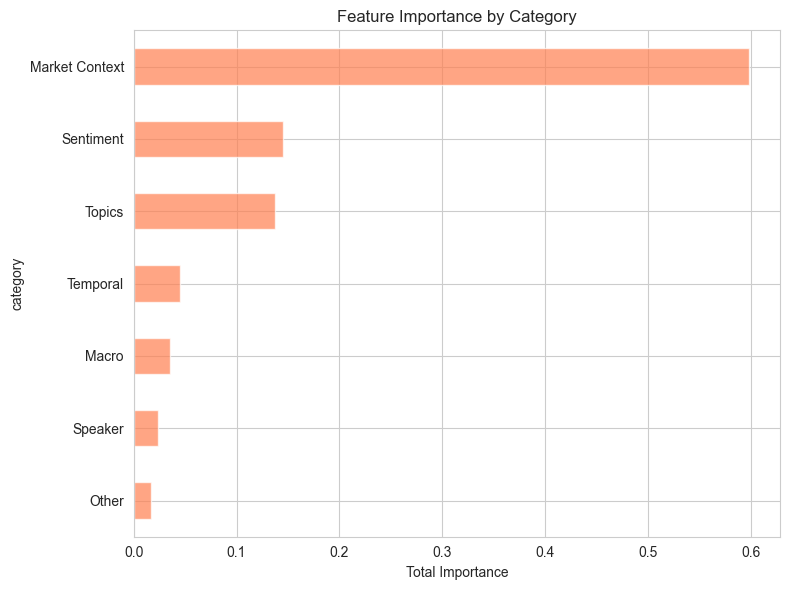

In [67]:
# Categorize features
def categorize_feature(feat):
    if any(x in feat.lower() for x in ['positive', 'negative', 'polarity', 'sentiment', 'hawk', 'dove', 'finbert', 'lm_']):
        return 'Sentiment'
    elif 'topic' in feat.lower():
        return 'Topics'
    elif any(x in feat.lower() for x in ['ret_', 'vol_']):
        return 'Market Context'
    elif any(x in feat.lower() for x in ['unemployment', 'interest']):
        return 'Macro'
    elif any(x in feat.lower() for x in ['year', 'month', 'day', 'crisis']):
        return 'Temporal'
    elif any(x in feat.lower() for x in ['chair', 'tokens']):
        return 'Speaker'
    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)

# Aggregate by category
category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)

print("\nFeature Importance by Category:")
print(category_importance)

# Plot
plt.figure(figsize=(8, 6))
category_importance.plot(kind='barh', color='coral', alpha=0.7)
plt.xlabel('Total Importance')
plt.title('Feature Importance by Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Time Series Cross-Validation

In [34]:
# Perform 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print("Performing Time Series Cross-Validation...\n")

cv_scores = []
fold_num = 1

for train_idx, val_idx in tscv.split(X):
    X_train_cv = X.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    y_train_cv = y_encoded.iloc[train_idx]
    y_val_cv = y_encoded.iloc[val_idx]
    
    # Train model
    rf_cv = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_cv.fit(X_train_cv, y_train_cv)
    
    # Evaluate
    y_pred_cv = rf_cv.predict(X_val_cv)
    acc_cv = accuracy_score(y_val_cv, y_pred_cv)
    f1_cv = f1_score(y_val_cv, y_pred_cv, average='weighted', zero_division=0)
    
    cv_scores.append({'fold': fold_num, 'accuracy': acc_cv, 'f1': f1_cv})
    print(f"Fold {fold_num}: Accuracy = {acc_cv:.4f}, F1 = {f1_cv:.4f}")
    fold_num += 1

cv_df = pd.DataFrame(cv_scores)
print(f"\n{'='*60}")
print(f"Cross-Validation Summary:")
print(f"Mean Accuracy: {cv_df['accuracy'].mean():.4f} (+/- {cv_df['accuracy'].std():.4f})")
print(f"Mean F1 Score: {cv_df['f1'].mean():.4f} (+/- {cv_df['f1'].std():.4f})")
print(f"{'='*60}")

Performing Time Series Cross-Validation...

Fold 1: Accuracy = 0.4310, F1 = 0.3956
Fold 2: Accuracy = 0.5152, F1 = 0.5073
Fold 3: Accuracy = 0.5387, F1 = 0.4779
Fold 4: Accuracy = 0.5589, F1 = 0.5084
Fold 5: Accuracy = 0.5623, F1 = 0.5500

Cross-Validation Summary:
Mean Accuracy: 0.5212 (+/- 0.0538)
Mean F1 Score: 0.4878 (+/- 0.0576)


## 11. Prediction Analysis

In [35]:
# Analyze when model works best
test_analysis = df.iloc[split_index:].copy()
test_analysis['true_class'] = y_test
test_analysis['pred_class'] = y_pred
test_analysis['correct'] = (y_test == y_pred).astype(int)

print("Accuracy by Speaker Type:")
print("\nFed Chair vs Others:")
speaker_acc = test_analysis.groupby('is_chair')['correct'].agg(['mean', 'count'])
speaker_acc.index = ['Other Officials', 'Fed Chair']
print(speaker_acc)

print("\nAccuracy by Time Period:")
period_mapping = {1: 'Pre-Crisis', 0: 'Other'}
if 'crisis' in test_analysis.columns:
    test_analysis['period'] = test_analysis.apply(
        lambda x: 'Crisis' if x['crisis'] == 1 else ('Pre-Crisis' if x['pre_crisis'] == 1 else 'Post-Crisis'),
        axis=1
    )
    print(test_analysis.groupby('period')['correct'].agg(['mean', 'count']))

Accuracy by Speaker Type:

Fed Chair vs Others:
                     mean  count
Other Officials  0.570755    212
Fed Chair        0.586207    145

Accuracy by Time Period:
                 mean  count
period                      
Post-Crisis  0.577031    357


## 12. Save Results

In [36]:
# Save predictions
test_results = df.iloc[split_index:].copy()
test_results['true_class'] = y_test
test_results['predicted_class'] = y_pred
test_results['correct'] = (y_test == y_pred).astype(int)

# Add probability scores
test_results['prob_bearish'] = y_pred_proba[:, 0]
test_results['prob_neutral'] = y_pred_proba[:, 1]
test_results['prob_bullish'] = y_pred_proba[:, 2]

predictions_df = test_results[[
    'date', 'speaker', 'true_class', 'predicted_class', 'correct',
    'prob_bearish', 'prob_neutral', 'prob_bullish'
]]
predictions_df.to_csv('random_forest_predictions.csv', index=False)
print("✅ Predictions saved: random_forest_predictions.csv")

# Save feature importance
importance_df.to_csv('random_forest_feature_importance.csv', index=False)
print("✅ Feature importance saved: random_forest_feature_importance.csv")

# Save model
import pickle
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✅ Model saved: random_forest_model.pkl")

✅ Predictions saved: random_forest_predictions.csv
✅ Feature importance saved: random_forest_feature_importance.csv
✅ Model saved: random_forest_model.pkl


## 13. Summary

In [37]:
print("="*80)
print("RANDOM FOREST - FINAL SUMMARY")
print("="*80)
print(f"\n📊 Model: Random Forest Classifier ({rf_model.n_estimators} trees)")
print(f"🎯 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)")
print(f"\n📈 Performance:")
print(f"  - Test Accuracy: {acc:.4f}")
print(f"  - Baseline: {baseline_acc:.4f}")
print(f"  - Improvement: {(acc - baseline_acc)*100:.2f}%")
print(f"  - F1 Score: {f1:.4f}")
print(f"\n🔄 Cross-Validation:")
print(f"  - Mean Accuracy: {cv_df['accuracy'].mean():.4f}")
print(f"  - Std: {cv_df['accuracy'].std():.4f}")
print(f"\n🌟 Top 3 Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
print(f"\n📊 Feature Category Ranking:")
for cat, imp in category_importance.head(3).items():
    print(f"  - {cat}: {imp:.4f}")
print(f"\n💡 Interpretation:")
if acc > baseline_acc + 0.05:
    print("  ✅ Model shows strong predictive power!")
elif acc > baseline_acc:
    print("  ⚠️  Weak signal detected.")
else:
    print("  ❌ No improvement over baseline.")
print("\n" + "="*80)

RANDOM FOREST - FINAL SUMMARY

📊 Model: Random Forest Classifier (200 trees)
🎯 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)

📈 Performance:
  - Test Accuracy: 0.5770
  - Baseline: 0.6499
  - Improvement: -7.28%
  - F1 Score: 0.5391

🔄 Cross-Validation:
  - Mean Accuracy: 0.5212
  - Std: 0.0538

🌟 Top 3 Features:
  31. DJIA_ret_5d: 0.0483
  35. NDQ_ret_5d: 0.0464
  27. RSL_ret_5d: 0.0445

📊 Feature Category Ranking:
  - Market Context: 0.5914
  - Sentiment: 0.1621
  - Topics: 0.1246

💡 Interpretation:
  ❌ No improvement over baseline.

